In [9]:
import socket
import struct
import numpy as np
import time
import matplotlib
from matplotlib import pyplot as plt
import glob, os

In [10]:
computer_path = '/Users/HHG'
data_path = computer_path + '/FilesRepositories'
plot_path = data_path + '/Project/Transient_Sustained/'

#tdrDir = '/Users/HHG/FilesRepositories/AEDAT/TempFreq_bandandlowpass/'
tdrDir = '/Users/HHG/FilesRepositories/AEDAT/Transient_Sustained3/'
dataDir = tdrDir
os.chdir(dataDir)

tempdatalist = glob.glob("w2t*")
spatialdatalist = glob.glob("w2s*")
#tempdatalist = glob.glob("N1765t*")
#spatialdatalist = glob.glob("N1765s*")
tempdataread = []
spatialdataread = []

for i in tempdatalist:
    tempdataread.append(open(i,"rb"))
    
for i in spatialdatalist:
    spatialdataread.append(open(i,"rb"))
    debug = False

print len(tempdataread)
print len(spatialdataread)

6
3


In [11]:
def read_events(file):
    """ A simple function that read dynap-se events from cAER aedat 3.0 file format"""
    
    # raise Exception at end of file
    data = file.read(28)
    if(len(data) <= 0):
        print("read all data\n")
        raise NameError('END OF DATA')


    # read header
    eventtype = struct.unpack('H', data[0:2])[0]
    eventsource = struct.unpack('H', data[2:4])[0]
    eventsize = struct.unpack('I', data[4:8])[0]
    eventoffset = struct.unpack('I', data[8:12])[0]
    eventtsoverflow = struct.unpack('I', data[12:16])[0]
    eventcapacity = struct.unpack('I', data[16:20])[0]
    eventnumber = struct.unpack('I', data[20:24])[0]
    eventvalid = struct.unpack('I', data[24:28])[0]
    next_read = eventcapacity * eventsize  # we now read the full packet
    data = file.read(next_read)    
    counter = 0  # eventnumber[0]
    #spike events
    core_id_tot = []
    chip_id_tot = []
    neuron_id_tot = []
    ts_tot =[]
    #special events
    spec_type_tot =[]
    spec_ts_tot = []

    if(eventtype == 0):
        spec_type_tot =[]
        spec_ts_tot = []
        while(data[counter:counter + eventsize]):  # loop over all event packets
            special_data = struct.unpack('I', data[counter:counter + 4])[0]
            timestamp = struct.unpack('I', data[counter + 4:counter + 8])[0]
            spec_type = (special_data >> 1) & 0x0000007F
            spec_type_tot.append(spec_type)
            spec_ts_tot.append(timestamp)
            if(spec_type == 6 or spec_type == 7 or spec_type == 9 or spec_type == 10):
                print (timestamp, spec_type)
            counter = counter + eventsize        
    elif(eventtype == 12):
        while(data[counter:counter + eventsize]):  # loop over all event packets
            aer_data = struct.unpack('I', data[counter:counter + 4])[0]
            timestamp = struct.unpack('I', data[counter + 4:counter + 8])[0]
            core_id = (aer_data >> 1) & 0x0000001F
            chip_id = (aer_data >> 6) & 0x0000003F
            neuron_id = (aer_data >> 12) & 0x000FFFFF
            core_id_tot.append(core_id)
            chip_id_tot.append(chip_id)
            neuron_id_tot.append(neuron_id)
            ts_tot.append(timestamp)
            counter = counter + eventsize
            if(debug):          
                print("chip id "+str(chip_id)+'\n')
                print("core_id "+str(core_id)+'\n')
                print("neuron_id "+str(neuron_id)+'\n')
                print("timestamp "+str(timestamp)+'\n')
                print("####\n")


    return core_id_tot, chip_id_tot, neuron_id_tot, ts_tot, spec_type_tot, spec_ts_tot

In [12]:
def skip_header(file):
    ''' This function skip the standard header of the recording file '''
    line = file.readline()
    while line.startswith("#"):
        if ( line == '#!END-HEADER\r\n'):
            break
        else:
            line = file.readline()

In [13]:
done_reading_temp = [False] * len(tempdataread)
done_reading_spatial = [False] * len(spatialdataread)

for data in tempdataread:
    skip_header(data)
for data in spatialdataread:
    skip_header(data)
    
times_t = []
neuron_17t = []
neuron_65t = []

times_s = []
neuron_17s = []
neuron_65s = []

for k in range(2):
    for i in range(len(tempdataread)):
        chip_id_tot = []
        core_id_tot = []
        neuron_id_tot = []
        ts_tot  = []
        spec_type_tot = []
        spec_ts_tot = []
        
        if (k==0):
            done_reading = done_reading_temp
            datareadlist = tempdataread
        elif (k==1):
            done_reading = done_reading_spatial
            datareadlist = spatialdataread
        while(done_reading[i] == False):
            try:
                core_id, chip_id, neuron_id, ts, spec_type, spec_ts = read_events(datareadlist[i])
                core_id_tot.extend(np.array(core_id))
                chip_id_tot.extend(np.array(chip_id))
                neuron_id_tot.extend(np.array(neuron_id))
                ts_tot.extend(np.array(ts))
                spec_type_tot.extend(np.array(spec_type))
                spec_ts_tot.extend(np.array(spec_ts))
                    
            except NameError:
                datareadlist[i].close()
                done_reading[i] = True
        neuron_id_d = []
        ts_id_d = []
        for chip, core, neur, ts in zip(chip_id_tot, core_id_tot, neuron_id_tot, ts_tot):
            if chip == 1 and core == 2:
                neuron_id_d.append(neur)
                ts_id_d.append(ts)
        if (k==0):
            times_t.append(ts_tot[-1]-ts_tot[0])
            neuron_17t.append(neuron_id_d.count(17))
            neuron_65t.append(neuron_id_d.count(65))
        if (k==1):
            times_s.append(ts_tot[-1]-ts_tot[0])
            neuron_17s.append(neuron_id_d.count(17))
            neuron_65s.append(neuron_id_d.count(65))

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data

read all data



IndexError: list index out of range

In [14]:
activity_17t = []
activity_65t = []
activity_17s = []
activity_65s = []

times_tsec = [i * (10**-6) for i in times_t]
times_ssec = [i * (10**-6) for i in times_s]

for i,count in enumerate(neuron_17t):
    activity_17t.append(count/times_tsec[i])
print activity_17t

for i,count in enumerate(neuron_65t):
    activity_65t.append(count/times_tsec[i])
print activity_65t

for i,count in enumerate(neuron_17s):
    activity_17s.append(count/times_ssec[i])
print activity_17s

for i,count in enumerate(neuron_65s):
    activity_65s.append(count/times_ssec[i])
print activity_65s



[1.2953498752966677, 5.1334807669009592, 8.2927041642423731, 9.9112873216365855, 6.5355738514350712, 6.7411817571047434]
[1.5544198503560012, 4.5174630748728442, 8.0488011005881859, 9.6893928293611395, 11.393876537457601, 10.880197499161282]
[0.72539423881532761, 0.93633493599542106, 0.85308776538494024]
[2.5906937100547416, 7.9588469559610786, 1.6113880012826649]


In [15]:
print activity_17s
activity_17s.insert(1,activity_17t[3])
activity_65s.insert(1,activity_65t[3])
print activity_17s

[0.72539423881532761, 0.93633493599542106, 0.85308776538494024]
[0.72539423881532761, 9.9112873216365855, 0.93633493599542106, 0.85308776538494024]


In [16]:
activity_17s.insert(0,activity_17s[3])
activity_65s.insert(0,activity_65s[3])
print activity_17s

[0.85308776538494024, 0.72539423881532761, 9.9112873216365855, 0.93633493599542106, 0.85308776538494024]


In [7]:
#item_65 = min(activity_65s[0],activity_65s[1])
#item_17 = min(activity_17s[0],activity_17s[1])
#activity_17s.remove(item_17)
#activity_65s.remove(item_65)


In [8]:
#activity_17s.insert(0,activity_17s[3])
#activity_65s.insert(0,activity_65s[3])
print activity_17s
print activity_65s
#del activity_17s[1]

[0.22522573249038849, 4.4478752729883455, 2.6506103934047993, 0.12077380744621249, 0.22522573249038849]
[0.22522573249038849, 17.944876101366773, 23.735011250033885, 2.2947023414780374, 0.22522573249038849]


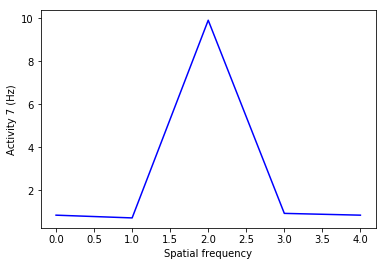

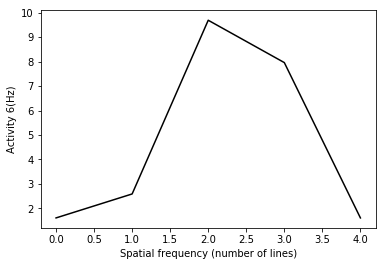

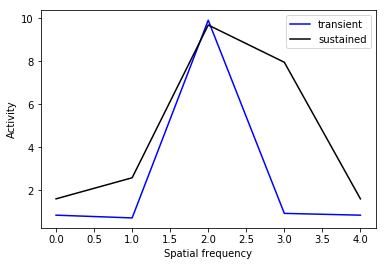

In [17]:
#Spatial plots
spatial = [0,1,2,3,4]
#spatial2 = [0,2,3,4]
fig1 = plt.figure()
plt.plot(spatial, activity_17s, 'b-')
plt.xlabel('Spatial frequency')#number of lines    
plt.ylabel('Activity 7 (Hz)')#17
fig1.savefig(plot_path + 'Activity17vsSpatial_tran', format='png', dpi=200)

fig2 = plt.figure()
plt.plot(spatial, activity_65s, 'k-')
plt.xlabel('Spatial frequency (number of lines)')    
plt.ylabel('Activity 6(Hz)')#65
fig2.savefig(plot_path + 'Activity65vsSpatial_sust', format='png', dpi=200)

fig3 = plt.figure()
plt.plot(spatial, activity_17s, 'b-')
plt.plot(spatial, activity_65s, 'k-')
plt.xlabel('Spatial frequency')    
plt.ylabel('Activity')
plt.legend(['transient', 'sustained'], loc='upper right')
fig3.savefig(plot_path + 'TransSust_spatial', format='png', dpi=200)

plt.show()

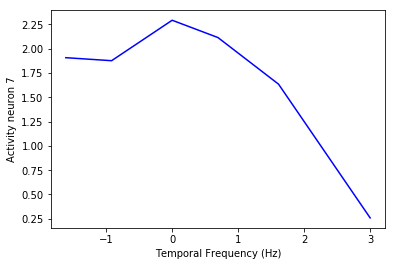

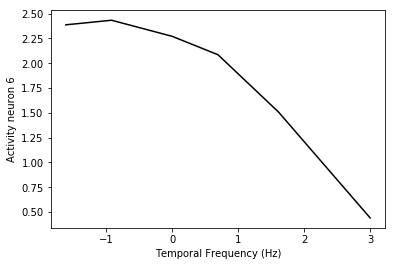

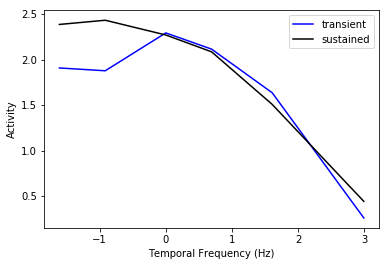

In [18]:
#Temporal plots
freq = [20,5,2,1,0.4,0.2]
plt.clf()
fig4 = plt.figure()
plt.plot(np.log(freq), np.log(activity_17t), 'b-')
#plt.plot(np.log(freq),(activity_154), 'kx')
plt.ylabel('Activity neuron 7')#17    
plt.xlabel('Temporal Frequency (Hz)')
fig4.savefig(plot_path + 'Activity17vsTemporal_tran', format='png', dpi=200)

fig5 = plt.figure()
plt.plot(np.log(freq), np.log(activity_65t), 'k-')
plt.ylabel('Activity neuron 6')#65    
plt.xlabel('Temporal Frequency (Hz)')
fig5.savefig(plot_path + 'Activity17vsTemporal_sust', format='png', dpi=200)

fig6 = plt.figure()
plt.plot(np.log(freq),np.log(activity_17t), 'b-')
plt.plot(np.log(freq),np.log(activity_65t), 'k-')
plt.ylabel('Activity')    
plt.xlabel('Temporal Frequency (Hz)')
plt.legend(['transient', 'sustained'], loc='upper right')
fig6.savefig(plot_path + 'TransSust_temp', format='png', dpi=200)

plt.show()